<a href="https://colab.research.google.com/github/paolapt/8puzzle/blob/main/Reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install gymnasium

In [ ]:
import gymnasium as gym
import numpy as np
import random
from gymnasium import spaces

In [ ]:
class Entorno_almacen(gym.Env):
    def __init__(self):
        super(Entorno_almacen, self).__init__()

        # Tamaño del entorno
        self.size = 10  # 10x10 grid

        # Espacio de observación y acción
        self.observation_space = spaces.Discrete(self.size * self.size)
        self.action_space = spaces.Discrete(4)  # 0: Arriba, 1: Abajo, 2: Izquierda, 3: Derecha

        # Posición inicial del agente
        self.agent_pos = [0, 0]
        self.robots = [[6, 8], [9, 6]]
        self.energy_level = 100
        self.reward = 0
        self.picked_up = False
        self.n_items = 0

        # Definir el mapa
        self.mapa = np.array([
            list("..O...W..."),
            list("O..W..W..."),
            list("...O..D..."),
            list("W...D....."),
            list("....S.W..."),
            list("D..W......"),
            list("..W...W..."),
            list("D...W.D..."),
            list("..O......."),
            list("WW........")
        ])

    def observation(self):
        # La observación es la casilla en la que se encuentra el jugador
        return self.size * self.agent_pos[0] + self.agent_pos[1]

    def reset(self):
        # Reiniciar el entorno
        self.agent_pos = [0, 0]
        self.robots = [[6, 8], [9, 6]]
        self.energy_level = 100
        self.reward = 0
        self.picked_up = False
        self.n_items = 0
        self.mapa = np.array([
            list("..O...W..."),
            list("O..W..W..."),
            list("...O..D..."),
            list("W...D....."),
            list("....S.W..."),
            list("D..W......"),
            list("..W...W..."),
            list("D...W.D..."),
            list("..O......."),
            list("WW........")
        ])


        return self.observation(), {}

    def done(self):
      if self.n_items >= 2:
          if self.mapa[self.agent_pos[0], self.agent_pos[1]] == 'D':
              print("GANASTE")
              return True
      if self.energy_level <= 0:
          print("PERDISTE")
          return True
      return False



    def item_collected(self):
      if self.mapa[self.agent_pos[0], self.agent_pos[1]] == 'O':  # Solo verifica si hay un objeto
          self.n_items += 1
          self.mapa[self.agent_pos[0], self.agent_pos[1]] = '.'  # Eliminar el objeto del mapa
          print(f"Objeto recogido. n_items = {self.n_items}")
          return True
      return False

    def rewards(self):
        # Verificar colisiones con robots
        for robot in self.robots:
            if self.agent_pos == robot:
                return -10  # Penalización por colisión con robots

        if self.mapa[self.agent_pos[0], self.agent_pos[1]] == 'D' and self.n_items > 0:
            #self.n_items += 1  # Entregar un objeto
            #print(f"Objeto entregado. n_items = {self.n_items}")
            return 20  # Recompensa por entrega
        elif self.mapa[self.agent_pos[0], self.agent_pos[1]] == 'W':
            return -10
        elif self.mapa[self.agent_pos[0], self.agent_pos[1]] == 'S':
            return -10
        elif self.energy_level <= 0:
            return -5
        elif self.item_collected():  # Si se recolectó un objeto
            return 10  # Recompensa por recolectar un objeto
        return -1  # Penalización por cada paso



    def es_movimiento_valido(self, nueva_pos):
        # Verificar si la nueva posición es válida
        if (nueva_pos[0] < 0 or nueva_pos[0] >= self.size or
            nueva_pos[1] < 0 or nueva_pos[1] >= self.size):
            return False

        if self.mapa[nueva_pos[0], nueva_pos[1]] in ['W', 'S']:
            return False

        return True

    def move_robots(self):
        # Mover los robots de manera aleatoria
        for i, robot in enumerate(self.robots):
            action = random.choice([0, 1, 2, 3])
            new_pos = robot.copy()
            if action == 0: new_pos[0] -= 1  # Arriba
            elif action == 1: new_pos[0] += 1  # Abajo
            elif action == 2: new_pos[1] -= 1  # Izquierda
            elif action == 3: new_pos[1] += 1  # Derecha

            if self.es_movimiento_valido(new_pos):
                self.robots[i] = new_pos

    def step(self, action):
      if action not in range(4):
          raise ValueError("Invalid action")

      if action == 0:  # Arriba
          new_pos = [self.agent_pos[0] - 1, self.agent_pos[1]]
      elif action == 1:  # Abajo
          new_pos = [self.agent_pos[0] + 1, self.agent_pos[1]]
      elif action == 2:  # Izquierda
          new_pos = [self.agent_pos[0], self.agent_pos[1] - 1]
      elif action == 3:  # Derecha
          new_pos = [self.agent_pos[0], self.agent_pos[1] + 1]

      # Verificar si la nueva posición es válida
      if not self.es_movimiento_valido(new_pos):
          #print("Chocó contra pared")
          reward = -10  # Penalización por colisión
          done = self.done()  # Verificar si el juego ha terminado
          return self.observation(), reward, done, {"player": self.agent_pos, "goal": self.n_items}

      # Mover al agente
      self.agent_pos = new_pos

      # Verificar colisión con enemigos antes de moverlos
      for robot in self.robots:
          if self.agent_pos == robot:
              reward = -10  # Penalización por colisión con enemigo
              self.energy_level -= 1
              done = self.done()
              return self.observation(), reward, done, {"player": self.agent_pos, "goal": self.n_items}

      self.move_robots()
      self.energy_level -= 1

      for robot in self.robots:
          if self.agent_pos == robot:
              reward = -10  # Penalización por colisión con enemigo
              done = self.done()
              return self.observation(), reward, done, {"player": self.agent_pos, "goal": self.n_items}

      reward = self.rewards()
      done = self.done()  # Verificar si el juego ha terminado

      return self.observation(), reward, done, {"player": self.agent_pos, "goal": self.n_items}


    def render(self):
      for i in range(self.size):
          for j in range(self.size):
              # Verificar si hay un enemigo en esta posición
              is_enemy = False
              for robot in self.robots:
                  if [i, j] == robot: # Representar enemigo
                      print("😈", end="")
                      is_enemy = True
                      break

              if is_enemy:
                  continue  # Continuar al siguiente punto si ya se imprimió un enemigo

              # Posición del agente
              if [i, j] == self.agent_pos:  # Render the agent's position
                  print("🤖", end="")  # Representing agent as "A"
              elif self.mapa[i][j] == 'W':  # Wall
                  print("🟫", end="")
              elif self.mapa[i][j] == 'S':  # Shelf
                  print("📚", end="")
              elif self.mapa[i][j] == 'O':  # Object
                  print("📦", end="")
              elif self.mapa[i][j] == 'D':  # Delivery point
                  print("🏁", end="")
              elif self.mapa[i][j] == '.':  # Empty space
                  print("⬜️", end="")
          print()

# Prueba del entorno
env = Entorno_almacen()
obs, _ = env.reset()
done = False
while not done:
    env.render()
    obs, reward, done, info = env.step(random.randint(0, 3))
    print(f"Observación: {obs}, Posición agente: {info['player']}, Objetos recolectados: {env.n_items}, Energía: {env.energy_level}, Recompensa: {reward}, Finalizado: {done}")

env.close()

🤖⬜️📦⬜️⬜️⬜️🟫⬜️⬜️⬜️
📦⬜️⬜️🟫⬜️⬜️🟫⬜️⬜️⬜️
⬜️⬜️⬜️📦⬜️⬜️🏁⬜️⬜️⬜️
🟫⬜️⬜️⬜️🏁⬜️⬜️⬜️⬜️⬜️
⬜️⬜️⬜️⬜️📚⬜️🟫⬜️⬜️⬜️
🏁⬜️⬜️🟫⬜️⬜️⬜️⬜️⬜️⬜️
⬜️⬜️🟫⬜️⬜️⬜️🟫⬜️😈⬜️
🏁⬜️⬜️⬜️🟫⬜️🏁⬜️⬜️⬜️
⬜️⬜️📦⬜️⬜️⬜️⬜️⬜️⬜️⬜️
🟫🟫⬜️⬜️⬜️⬜️😈⬜️⬜️⬜️
Observación: 1, Posición agente: [0, 1], Objetos recolectados: 0, Energía: 99, Recompensa: -1, Finalizado: False
⬜️🤖📦⬜️⬜️⬜️🟫⬜️⬜️⬜️
📦⬜️⬜️🟫⬜️⬜️🟫⬜️⬜️⬜️
⬜️⬜️⬜️📦⬜️⬜️🏁⬜️⬜️⬜️
🟫⬜️⬜️⬜️🏁⬜️⬜️⬜️⬜️⬜️
⬜️⬜️⬜️⬜️📚⬜️🟫⬜️⬜️⬜️
🏁⬜️⬜️🟫⬜️⬜️⬜️⬜️⬜️⬜️
⬜️⬜️🟫⬜️⬜️⬜️🟫⬜️⬜️⬜️
🏁⬜️⬜️⬜️🟫⬜️🏁⬜️😈⬜️
⬜️⬜️📦⬜️⬜️⬜️⬜️⬜️⬜️⬜️
🟫🟫⬜️⬜️⬜️⬜️😈⬜️⬜️⬜️
Objeto recogido. n_items = 1
Observación: 2, Posición agente: [0, 2], Objetos recolectados: 1, Energía: 98, Recompensa: 10, Finalizado: False
⬜️⬜️🤖⬜️⬜️⬜️🟫⬜️⬜️⬜️
📦⬜️⬜️🟫⬜️⬜️🟫⬜️⬜️⬜️
⬜️⬜️⬜️📦⬜️⬜️🏁⬜️⬜️⬜️
🟫⬜️⬜️⬜️🏁⬜️⬜️⬜️⬜️⬜️
⬜️⬜️⬜️⬜️📚⬜️🟫⬜️⬜️⬜️
🏁⬜️⬜️🟫⬜️⬜️⬜️⬜️⬜️⬜️
⬜️⬜️🟫⬜️⬜️⬜️🟫⬜️😈⬜️
🏁⬜️⬜️⬜️🟫⬜️🏁⬜️⬜️⬜️
⬜️⬜️📦⬜️⬜️⬜️⬜️⬜️⬜️⬜️
🟫🟫⬜️⬜️⬜️😈⬜️⬜️⬜️⬜️
Observación: 2, Posición agente: [0, 2], Objetos recolectados: 1, Energía: 98, Recompensa: -10, Finalizado: False
⬜️⬜️🤖⬜️⬜️⬜️🟫⬜️⬜️⬜️
📦⬜️⬜️🟫⬜️⬜️🟫⬜️⬜️⬜️
⬜️⬜️⬜️📦⬜️⬜️🏁⬜️⬜️⬜️
🟫⬜️⬜️⬜️🏁⬜️⬜️⬜️⬜️

Q - LEARNING

There are  100  possible states
There are  4  possible actions


  1%|          | 84/10000 [00:00<00:12, 824.56it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
Objeto recogido. n_items = 4
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
Objeto recogido. n_items = 1
Objeto recogido.

  4%|▎         | 354/10000 [00:00<00:11, 872.86it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items =

  7%|▋         | 680/10000 [00:00<00:09, 1019.68it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objet

  9%|▉         | 916/10000 [00:00<00:08, 1063.13it/s]

Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items =

 13%|█▎        | 1332/10000 [00:01<00:06, 1279.11it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items =

 17%|█▋        | 1727/10000 [00:01<00:05, 1635.32it/s]

Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items =

 20%|██        | 2035/10000 [00:01<00:05, 1334.60it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items =

 25%|██▍       | 2480/10000 [00:01<00:04, 1753.58it/s]

GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n

 30%|██▉       | 2973/10000 [00:02<00:03, 2081.43it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objet

 34%|███▍      | 3384/10000 [00:02<00:03, 1911.23it/s]

Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANAS

 38%|███▊      | 3767/10000 [00:02<00:03, 1739.21it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n

 42%|████▏     | 4213/10000 [00:02<00:02, 1976.36it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n

 51%|█████▏    | 5143/10000 [00:03<00:01, 2665.03it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n

 57%|█████▋    | 5668/10000 [00:03<00:01, 2447.42it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto rec

 63%|██████▎   | 6256/10000 [00:03<00:01, 2519.43it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto rec

 69%|██████▉   | 6938/10000 [00:03<00:01, 3012.41it/s]

Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto rec

 75%|███████▌  | 7521/10000 [00:04<00:00, 2614.69it/s]

Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto rec

 83%|████████▎ | 8349/10000 [00:04<00:00, 2536.33it/s]

Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n

 91%|█████████ | 9121/10000 [00:04<00:00, 3175.97it/s]

GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Ob

100%|██████████| 10000/10000 [00:04<00:00, 2064.06it/s]

GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
Objeto recogido. n_items = 3
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto recogido. n_items = 2
GANASTE
Objeto recogido. n_items = 1
Objeto rec

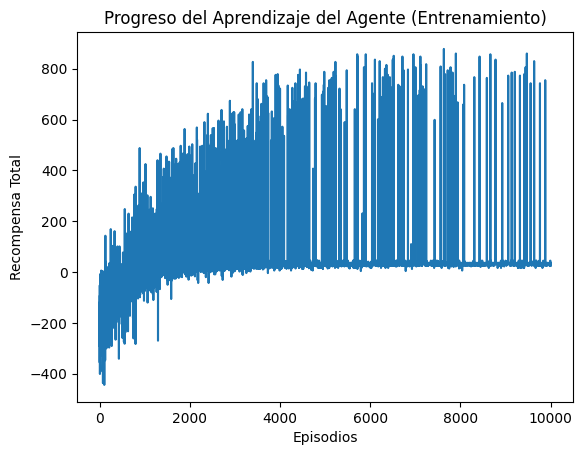

Recompensa media: 41.16 ± 109.36
Q-table después del entrenamiento:
[[ 8.48835820e+02  8.55998932e+02  8.48946196e+02  8.73403794e+02]
 [ 8.58798128e+02  8.62691695e+02  8.58332857e+02  8.83528588e+02]
 [ 8.56899541e+02  8.82643025e+02  8.67890299e+02  8.55076471e+02]
 [ 4.72937335e+02  4.62875651e+02  8.68572756e+02  4.52531440e+02]
 [ 1.98019052e+02  6.85630194e+02  2.19752046e+02  1.33996572e+02]
 [ 4.76549196e+01  1.14673668e+02  3.18824250e+02  6.30870886e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.38993958e+00 -6.86167165e-02 -1.43378279e+00 -2.06963202e-01]
 [-4.05558797e+00 -2.89977356e-01 -2.91632679e-01 -1.02260000e+00]
 [-3.72565108e+00 -2.31511166e-01 -2.02733494e-01 -3.74328134e+00]
 [ 8.58762008e+02  4.56132895e+02  5.31178870e+02  5.59549063e+02]
 [ 7.08941881e+02  8.78063363e+02  6.86841645e+02  6.91992774e+02]
 [ 8.66691653e+02  8.92697177e+02  8.64670238e+02  8.68411339e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000

In [25]:
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

# Crear el entorno
env = Entorno_almacen()

# Obtener el espacio de observación y acción
state_space = env.observation_space.n  # Tamaño del espacio de observación
action_space = env.action_space.n  # Número de acciones posibles

print("There are ", state_space, " possible states")
print("There are ", action_space, " possible actions")  # que son 4

# Inicializar la Q-table
def initialize_q_table(state_space, action_space):
    return np.zeros((state_space, action_space))

Qtable_almacen = initialize_q_table(state_space, action_space)

# Política epsilon-greedy
def epsilon_greedy_policy(Qtable, state, epsilon):
    if np.random.rand() > epsilon:
        action = np.argmax(Qtable[state])  # Explotar: elegir la mejor acción
    else:
        action = env.action_space.sample()  # Explorar: elegir una acción aleatoria
    return action

# Parámetros de entrenamiento ajustados
n_training_episodes = 10000
learning_rate = 0.05  # Reducir la tasa de aprendizaje
gamma = 0.99  # Aumentar el factor de descuento

max_steps = 99
# Parámetros de evaluación
n_eval_episodes = 100
# Parámetros de exploración ajustados
max_epsilon = 1.0
min_epsilon = 0.05  # Aumentar el mínimo de epsilon
decay_rate = 0.0005  # Reducir el decaimiento de epsilon

# Función de entrenamiento
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    episode_rewards = []  # Para almacenar las recompensas de cada episodio

    for episode in trange(n_training_episodes):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        state = env.reset()[0]  # Obtener el estado inicial
        total_rewards = 0
        done = False

        for _ in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)
            new_state, reward, done, _ = env.step(action)

            # Actualización de la Q-table
            Qtable[state, action] = Qtable[state, action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state, action]
            )

            total_rewards += reward
            state = new_state
            #if episode >=1500:
              #print(f"Episode {episode}, Step {_}, State {state}, Action {action}, Reward {reward}, New State {new_state}")


            if done:
                break

        episode_rewards.append(total_rewards)

    # Graficar las recompensas durante el entrenamiento
    plt.plot(episode_rewards)
    plt.xlabel("Episodios")
    plt.ylabel("Recompensa Total")
    plt.title("Progreso del Aprendizaje del Agente (Entrenamiento)")
    plt.show()

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    print(f"Recompensa media: {mean_reward:.2f} ± {std_reward:.2f}")

    return Qtable

# Entrenar el agente
Qtable_almacen = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_almacen)
print("Q-table después del entrenamiento:")
print(Qtable_almacen)

# Evaluar el agente
def evaluate_agent(env, max_steps, n_eval_episodes, Qtable):
    episode_rewards = []
    successful_deliveries = 0
    total_steps = 0
    total_energy_used = 0

    for episode in range(n_eval_episodes):
        state = env.reset()[0]  # Obtener el estado inicial
        total_rewards = 0
        done = False
        steps = 0

        for _ in range(max_steps):
            action = np.argmax(Qtable[state])  # Política greedy
            new_state, reward, done, _ = env.step(action)
            total_rewards += reward
            steps += 1

            print(f"Episode {episode}, Items Delivered: {env.n_items}")
            if done:
              if env.n_items >= 2:
                successful_deliveries += env.n_items
                break

            state = new_state

        total_steps += steps
        total_energy_used += (100 - env.energy_level)  # energía usada = 100 - lo que queda

    # Calculate metrics for analysis
    avg_steps_per_delivery = total_steps / n_eval_episodes
    energy_usage_efficiency = total_energy_used / n_eval_episodes

    # Print metrics
    print(f"Number of successful deliveries: {successful_deliveries} deliveries in {n_eval_episodes} episodes")
    print(f"Average steps per delivery: {avg_steps_per_delivery:.2f}")
    print(f"Energy usage efficiency: {energy_usage_efficiency:.2f} energy units per episode")

    return successful_deliveries, avg_steps_per_delivery, energy_usage_efficiency

# Evaluar el agente entrenado
successful_deliveries, avg_steps, energy_efficiency = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_almacen)
